# **Neural Style Transfer**

Neural Style Transfer is another awesome implementation of CNNs.<br>
We take pretrained CNN, pass 2 images (content image and style image) through it to calculate features extracted on specified layers<br>
Then we clone content image and optimize it to keep content from image content and to replicate the style.<br>
As a loss for the process we combine 2 losses:<br>
1) Content Loss (just MSE between content image and generated image)
2) Style Loss (trickier one), for this we flatten each channel and calculate gram matrix ($F F^T$). We do it to cross-correlate channels and extract general style details. This cross-correlation just searches for simmilar patterns over different channels.<br>
This gives us awesome results!<br>
<img src="https://docs.pytorch.org/tutorials/_images/neuralstyle.png">


In [204]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, models

In [205]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [206]:
og_sizes = {}


def img_to_tensor(image_path):
  img = Image.open(image_path).convert("RGB")
  transform = transforms.Compose([
      transforms.Resize((512, 512)),
      transforms.ToTensor()
  ])
  og_sizes[image_path] = img.size  # Save original size
  return transform(img).unsqueeze(0).to(device)


def tensor_to_img(tensor):
  tensor = tensor.squeeze(0).cpu().clone()
  tensor = torch.clamp(tensor, 0, 1)
  img = transforms.ToPILImage()(tensor)
  return img

In [207]:
class VGGTransfer(nn.Module):
  def __init__(self, layers=['0', '5', '10', '19', '28']):
    super().__init__()
    self.layers = layers
    self.model = models.vgg19(pretrained=True).features  # We don't need classifier

  def forward(self, input):
    features = []
    for name, layer in self.model._modules.items():
      input = layer(input)
      if name in self.layers:
        features.append(input)  # Save output from selected layers
    return features

In [208]:
content = img_to_tensor("content.jpg")
style = img_to_tensor("style.jpg")

In [209]:
vgg = VGGTransfer().to(device).eval()
for parameter in vgg.parameters():
  parameter.requires_grad_(False)

content_feats = vgg(content)
style_feats = vgg(style)

In [210]:
generated = content.clone().requires_grad_(True)

In [211]:
optimizer = torch.optim.Adam([generated], lr=0.01)
EPOCHS = 800

alpha = 0.1  # Content Weight
beta = 50  # Style Weight (I came up with this one, to prioritize style)

for epoch in range(EPOCHS):
  gen_feats = vgg(generated)

  content_loss = 0
  style_loss = 0
  for c, s, g in zip(content_feats, style_feats, gen_feats):
    # Content Loss
    content_loss += torch.mean((g - c)**2)

    # Style Loss
    b, c, h, w = s.size()
    s = s.view(b * c, h * w)
    g = g.view(b * c, h * w)

    s_gram = torch.mm(s, s.t())
    g_gram = torch.mm(g, g.t())

    style_loss += torch.mean((g_gram - s_gram)**2) / (b * c * h * w)

  loss = alpha * content_loss + beta * style_loss
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  with torch.no_grad():
    generated.clamp_(0, 1)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss.item() / (beta*10)}")

Epoch: 0 | Loss: 1.958131591796875
Epoch: 100 | Loss: 0.02697452163696289
Epoch: 200 | Loss: 0.016222675323486327
Epoch: 300 | Loss: 0.014242406845092773
Epoch: 400 | Loss: 0.010847783088684082
Epoch: 500 | Loss: 0.0103974609375
Epoch: 600 | Loss: 0.009111513137817382
Epoch: 700 | Loss: 0.00818878936767578


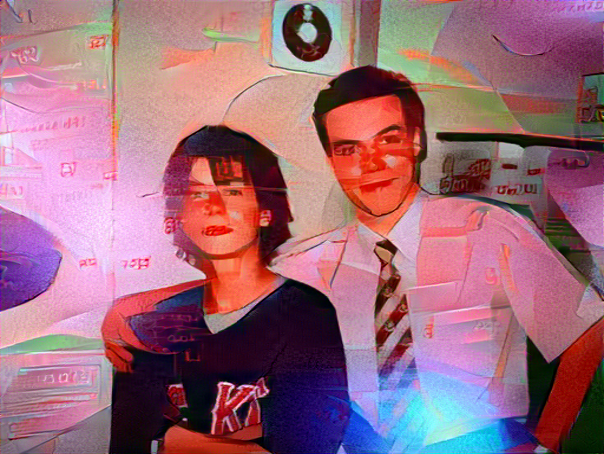

In [212]:
imege = tensor_to_img(generated)
imege.resize(og_sizes["content.jpg"])

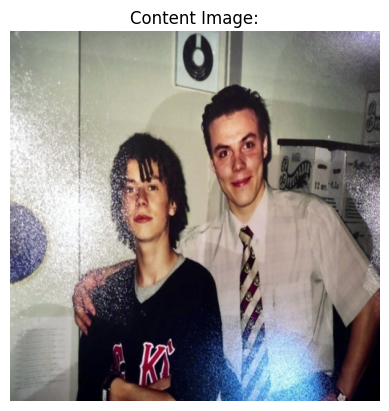

In [216]:
plt.title("Content Image:")
plt.axis("off")
plt.imshow(content.squeeze(0).cpu().clone().permute(1, 2, 0));

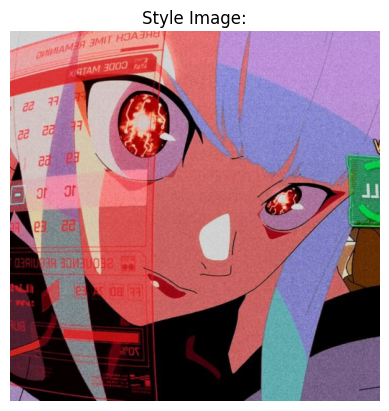

In [217]:
plt.title("Style Image:")
plt.axis("off")
plt.imshow(style.squeeze(0).cpu().clone().permute(1, 2, 0));

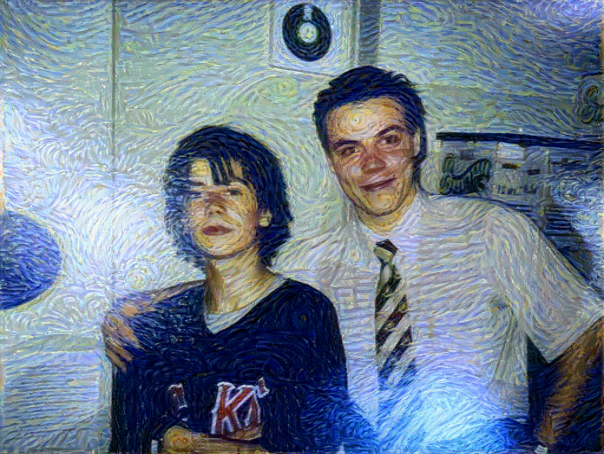
<br> Another cool result! (Van Gogh)